In [ ]:
# import modules
import math
import sys
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx

from leap_ec.individual import Individual
from leap_ec.decoder import IdentityDecoder
from leap_ec.representation import Representation
from leap_ec.algorithm import multi_population_ea
from leap_ec.context import context

import leap_ec.ops as ops
from leap_ec import probe
from leap_ec.algorithm import multi_population_ea

from leap_ec.real_rep.problems import SchwefelProblem
from leap_ec.real_rep.ops import mutate_gaussian
from leap_ec.real_rep.initializers import create_real_vector

import yfinance as yf
import numpy as np

# Read Data

In [ ]:
df = yf.download("AMZN",period = "max", interval = "1d")
df['Range'] = df['High'] - df['Low']
df['RangeOC'] = df['Open'] - df['Adj Close']
df

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
1997-05-15     2.437500     2.500000     1.927083     1.958333     1.958333   
1997-05-16     1.968750     1.979167     1.708333     1.729167     1.729167   
1997-05-19     1.760417     1.770833     1.625000     1.708333     1.708333   
1997-05-20     1.729167     1.750000     1.635417     1.635417     1.635417   
1997-05-21     1.635417     1.645833     1.375000     1.427083     1.427083   
...                 ...          ...          ...          ...          ...   
2021-03-18  3101.000000  3116.629883  3025.000000  3027.989990  3027.989990   
2021-03-19  3029.229980  3077.290039  3016.629883  3074.959961  3074.959961   
2021-03-22  3067.850098  3126.580078  3060.050049  3110.870117  3110.870117   
2021-03-23  3127.000000  3182.000000  3120.850098  3137.500000  3137.500000   
2021-03-24  3151.040039  3160.000000  3085.149902  3087.070068  3087.070068   

              Volume      Range    RangeOC  
Date                                        
1997-05-15  72156000   0.572917   0.479167  
1997-05-16  14700000   0.270834   0.239583  
1997-05-19   6106800   0.145833   0.052084  
1997-05-20   5467200   0.114583   0.093750  
1997-05-21  18853200   0.270833   0.208334  
...              ...        ...        ...  
2021-03-18   3649600  91.629883  73.010010  
2021-03-19   4616400  60.660156 -45.729980  
2021-03-22   2902200  66.530029 -43.020020  
2021-03-23   3810500  61.149902 -10.500000  
2021-03-24   2834780  74.850098  63.969971  

[6004 rows x 8 columns]

In [ ]:
# Brownian motion replacement
mu,sigma = 0,1

brownian = []
n = len(df)*24
brownian.append(np.random.normal(mu, sigma))
for i in range(n):
    temp = brownian[i-1] + np.random.normal(mu, sigma)
    brownian.append(temp)

df['Open'] = brownian[8::24]
df['Close'] = brownian[16::24]
df['Adj Close'] = df['Close']

High_list = []
Low_list = []

for i in range(len(df)):
    High_list.append(max(brownian[8 + 24*i : 16 + 24* i])) # the highest price inside of the 8 trading hours
    Low_list.append(min(brownian[8 + 24*i : 16 + 24*i]))


df['High'] = High_list
df['Low'] = Low_list


# brownian = []
# brownian.append(np.random.normal(mu, sigma))
# for i in range(1,len(df)):
#     temp = brownian[i-1] + np.random.normal(mu, sigma)
#     brownian.append(temp)
# df['Open'] = brownian

# brownian = []
# brownian.append(np.random.normal(mu, sigma))
# for i in range(1,len(df)):
#     temp = brownian[i-1] + np.random.normal(mu, sigma)
#     brownian.append(temp)
# df['High'] = brownian

# brownian = []
# brownian.append(np.random.normal(mu, sigma))
# for i in range(1,len(df)):
#     temp = brownian[i-1] + np.random.normal(mu, sigma)
#     brownian.append(temp)
# df['Low'] = brownian

# brownian = []
# brownian.append(np.random.normal(mu, sigma))
# for i in range(1,len(df)):
#     temp = brownian[i-1] + np.random.normal(mu, sigma)
#     brownian.append(temp)
# df['Close'] = brownian

# brownian = []
# brownian.append(np.random.normal(mu, sigma))
# for i in range(1,len(df)):
#     temp = brownian[i-1] + np.random.normal(mu, sigma)
#     brownian.append(temp)
# df['Adj Close'] = brownian

df

Open        High         Low       Close   Adj Close  \
Date                                                                     
1997-05-15    1.928199    6.314583    0.981499    0.668776    0.668776   
1997-05-16    6.499038    6.499038    4.630139    3.807152    3.807152   
1997-05-19    3.123676    9.618881    3.123676    3.482622    3.482622   
1997-05-20   -0.230336    6.642183   -2.558137   -3.301378   -3.301378   
1997-05-21   -2.022630    6.289671   -3.516703   -3.163368   -3.163368   
...                ...         ...         ...         ...         ...   
2021-03-18 -130.471309  101.034383 -131.678015 -130.260256 -130.260256   
2021-03-19 -127.673196  104.004128 -127.673196 -125.285232 -125.285232   
2021-03-22 -122.759294  102.744791 -123.907485 -123.764612 -123.764612   
2021-03-23 -123.540820  112.576052 -125.648692 -123.768134 -123.768134   
2021-03-24 -130.687166  114.959030 -132.325083 -132.504321 -132.504321   

              Volume      Range    RangeOC  
Date                                        
1997-05-15  72156000   0.572917   0.479167  
1997-05-16  14700000   0.270834   0.239583  
1997-05-19   6106800   0.145833   0.052084  
1997-05-20   5467200   0.114583   0.093750  
1997-05-21  18853200   0.270833   0.208334  
...              ...        ...        ...  
2021-03-18   3649600  91.629883  73.010010  
2021-03-19   4616400  60.660156 -45.729980  
2021-03-22   2902200  66.530029 -43.020020  
2021-03-23   3810500  61.149902 -10.500000  
2021-03-24   2834780  74.850098  63.969971  

[6004 rows x 8 columns]

<AxesSubplot:xlabel='Date'>

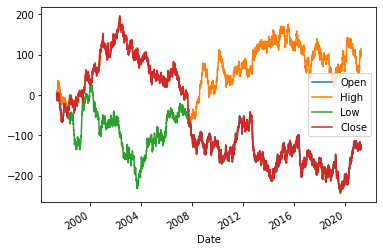

In [ ]:
df[['Open','High','Low','Close']].plot()

# Identify trend day and features day

In [ ]:
# Up and Down trend day
df.loc[(df['Open'] <= df['Low']+0.1*df['Range']) & (df['Adj Close'] >= df['High']-0.2*df['Range']), 'Up_Trend'] = 1
df.loc[(df['Open'] >= df['High']-0.1*df['Range']) & (df['Adj Close'] <= df['High']+0.2*df['Range']), 'Down_Trend'] = 1
df['Up_Trend'] = df['Up_Trend'].fillna(0)
df['Down_Trend'] = df['Down_Trend'].fillna(0)

In [ ]:
# NRk
for i in range(2,8):
    df['Previous{k}'.format(k = i)] = df['Range'].rolling(i).min().shift(i-1)
    df.loc[df['Range'] <= df['Previous{k}'.format(k = i)], 'NR{k}'.format(k = i)] = 1
    df = df.drop(['Previous{k}'.format(k = i)], axis=1)
    df['NR{k}'.format(k = i)] = df['NR{k}'.format(k = i)].fillna(0)

In [ ]:
# DOJI
# TODO: What does x effect? x: a small percentage of the range
x = 0.05
df.loc[df['RangeOC'].abs() <= x*df['Range'], 'DOJI'] = 1
df['DOJI'] = df['DOJI'].fillna(0)

In [ ]:
# Hook day
#for delta in range(0, 11):
delta = 0.5
df.loc[df['Open'].shift(-1) < df['Low']-delta, 'Up_Hook{d}'.format(d=delta)] = 1
df.loc[df['Open'].shift(-1) > df['High']+delta, 'Down_Hook{d}'.format(d=delta)] = 1
df['Up_Hook{d}'.format(d=delta)] = df['Up_Hook{d}'.format(d=delta)].fillna(0)
df['Down_Hook{d}'.format(d=delta)] = df['Down_Hook{d}'.format(d=delta)].fillna(0)
df[["Up_Hook0.5","Down_Hook0.5"]]

Up_Hook0.5  Down_Hook0.5
Date                                
1997-05-15         0.0           0.0
1997-05-16         1.0           0.0
1997-05-19         1.0           0.0
1997-05-20         0.0           0.0
1997-05-21         1.0           0.0
...                ...           ...
2021-03-18         0.0           0.0
2021-03-19         0.0           0.0
2021-03-22         0.0           0.0
2021-03-23         1.0           0.0
2021-03-24         0.0           0.0

[6004 rows x 2 columns]

# Features day membership functions

In [ ]:
# NRk membership function
ks = [4,6,7]
cs = [1/2,1/3,1/3]
v_mins = [2,3,4]
v_maxs = [4,6,7]

for i in range(0,len(ks)):
    # Generate other parameters in the function
    df['D{k}'.format(k = ks[i])] = df['NR{k}'.format(k = ks[i])].shift(1).rolling(ks[i]).sum()
    df['~R{k}'.format(k = ks[i])] = df['Range'].shift(1).rolling(ks[i]).max()
    df['eta{k}'.format(k = ks[i])] = (df['~R{k}'.format(k = ks[i])]-df['Range'])/df['~R{k}'.format(k = ks[i])]
    df['NR_x{k}'.format(k = ks[i])] = df['D{k}'.format(k = ks[i])] + df['eta{k}'.format(k = ks[i])]
    # Conditioinal membership function
    df.loc[df['NR_x{k}'.format(k = ks[i])] < v_mins[i], 'NR{k}_membership'.format(k = ks[i])] = 0
    df.loc[(df['NR_x{k}'.format(k = ks[i])] >= v_mins[i]) & (df['NR_x{k}'.format(k = ks[i])] < v_maxs[i]), 
           'NR{k}_membership'.format(k = ks[i])] = cs[i]*(df['NR_x{k}'.format(k = ks[i])] - v_mins[i])
    df.loc[df['NR_x{k}'.format(k = ks[i])] >= v_maxs[i], 'NR{k}_membership'.format(k = ks[i])] = 1
    # Drop unecessary columns
    df = df.drop(['D{k}'.format(k = ks[i])], axis=1)
    df = df.drop(['~R{k}'.format(k = ks[i])], axis=1)
    df = df.drop(['eta{k}'.format(k = ks[i])], axis=1)
    df = df.drop(['NR_x{k}'.format(k = ks[i])], axis=1)
    
#df[['Range','NR4','D4','~R4','eta4','NR_x4']].tail(10)
#df[df['NR4_membership'] != 0]

In [ ]:
# DOJI membership function
rhos = [0.05,0.10,0.15,0.20,0.25,0.30]
for rho in rhos:
    df.loc[(df['RangeOC'] >= 0) & (df['RangeOC']<= 2), 'DOJI{r}'.format(r = rho) ] = 1 - (df['RangeOC']/rho)
    df['DOJI{r}_membership'.format(r = rho)] = df['DOJI{r}'.format(r = rho)].fillna(0)

In [ ]:
# Hook day membership function
#for delta in range(0, 11):
delta = 0.5
# Generate other parameters in the function
df.loc[(df['Up_Hook{d}'.format(d=delta)] == 1), 'Hook{d}_x'.format(d=delta)] = df['Low']-delta-df['Open'].shift(1)
df.loc[(df['Down_Hook{d}'.format(d=delta)] == 1), 'Hook{d}_x'.format(d=delta)] = df['Open'].shift(1)-delta-df['High']
df['Hook{d}_x'.format(d=delta)] = df['Hook{d}_x'.format(d=delta)].fillna(0)
# Conditioinal membership function
df.loc[(df['Hook{d}_x'.format(d=delta)] < -1/2), 'Hook{d}_membership'.format(d=delta)] = 0
df.loc[(df['Hook{d}_x'.format(d=delta)] >= -1/2) & (df['Hook{d}_x'.format(d=delta)] < 0), 
       'Hook{d}_membership'.format(d=delta)] = 2*(df['Hook{d}_x'.format(d=delta)] + 0.5)
df.loc[(df['Hook{d}_x'.format(d=delta)] >= 0), 'Hook{d}_membership'.format(d=delta)] = 1
    
#df[(df['Hook2_membership']>0)&(df['Hook2_membership']!=1)]

In [ ]:
df

Open        High         Low       Close   Adj Close  \
Date                                                                     
1997-05-15    1.928199    6.314583    0.981499    0.668776    0.668776   
1997-05-16    6.499038    6.499038    4.630139    3.807152    3.807152   
1997-05-19    3.123676    9.618881    3.123676    3.482622    3.482622   
1997-05-20   -0.230336    6.642183   -2.558137   -3.301378   -3.301378   
1997-05-21   -2.022630    6.289671   -3.516703   -3.163368   -3.163368   
...                ...         ...         ...         ...         ...   
2021-03-18 -130.471309  101.034383 -131.678015 -130.260256 -130.260256   
2021-03-19 -127.673196  104.004128 -127.673196 -125.285232 -125.285232   
2021-03-22 -122.759294  102.744791 -123.907485 -123.764612 -123.764612   
2021-03-23 -123.540820  112.576052 -125.648692 -123.768134 -123.768134   
2021-03-24 -130.687166  114.959030 -132.325083 -132.504321 -132.504321   

              Volume      Range    RangeOC  Up_Trend  Down_Trend  ...  \
Date                                                              ...   
1997-05-15  72156000   0.572917   0.479167       0.0         0.0  ...   
1997-05-16  14700000   0.270834   0.239583       0.0         1.0  ...   
1997-05-19   6106800   0.145833   0.052084       0.0         0.0  ...   
1997-05-20   5467200   0.114583   0.093750       0.0         0.0  ...   
1997-05-21  18853200   0.270833   0.208334       0.0         0.0  ...   
...              ...        ...        ...       ...         ...  ...   
2021-03-18   3649600  91.629883  73.010010       0.0         0.0  ...   
2021-03-19   4616400  60.660156 -45.729980       0.0         0.0  ...   
2021-03-22   2902200  66.530029 -43.020020       0.0         0.0  ...   
2021-03-23   3810500  61.149902 -10.500000       0.0         0.0  ...   
2021-03-24   2834780  74.850098  63.969971       0.0         0.0  ...   

            DOJI0.15  DOJI0.15_membership   DOJI0.2  DOJI0.2_membership  \
Date                                                                      
1997-05-15 -2.194447            -2.194447 -1.395835           -1.395835   
1997-05-16 -0.597220            -0.597220 -0.197915           -0.197915   
1997-05-19  0.652774             0.652774  0.739580            0.739580   
1997-05-20  0.375000             0.375000  0.531250            0.531250   
1997-05-21 -0.388893            -0.388893 -0.041670           -0.041670   
...              ...                  ...       ...                 ...   
2021-03-18       NaN             0.000000       NaN            0.000000   
2021-03-19       NaN             0.000000       NaN            0.000000   
2021-03-22       NaN             0.000000       NaN            0.000000   
2021-03-23       NaN             0.000000       NaN            0.000000   
2021-03-24       NaN             0.000000       NaN            0.000000   

            DOJI0.25  DOJI0.25_membership   DOJI0.3  DOJI0.3_membership  \
Date                                                                      
1997-05-15 -0.916668            -0.916668 -0.597223           -0.597223   
1997-05-16  0.041668             0.041668  0.201390            0.201390   
1997-05-19  0.791664             0.791664  0.826387            0.826387   
1997-05-20  0.625000             0.625000  0.687500            0.687500   
1997-05-21  0.166664             0.166664  0.305553            0.305553   
...              ...                  ...       ...                 ...   
2021-03-18       NaN             0.000000       NaN            0.000000   
2021-03-19       NaN             0.000000       NaN            0.000000   
2021-03-22       NaN             0.000000       NaN            0.000000   
2021-03-23       NaN             0.000000       NaN            0.000000   
2021-03-24       NaN             0.000000       NaN            0.000000   

            Hook0.5_x  Hook0.5_membership  
Date                                       
1997-05-15   0.000000                 1.0  
1997-05-16   2.201940

# Singleton fuzzifier

## Vector of fuzzy numbers A

In [ ]:
A = df[["NR4_membership","NR6_membership","NR7_membership","DOJI0.1_membership","Hook0.5_membership"]]
A = A.iloc[7:]
A.to_csv("A.csv")  
A

NR4_membership  NR6_membership  NR7_membership  \
Date                                                         
1997-05-27        0.000000        0.000000             0.0   
1997-05-28        0.000000        0.000000             0.0   
1997-05-29        0.000000        0.000000             0.0   
1997-05-30        0.416667        0.000000             0.0   
1997-06-02        0.916667        0.000000             0.0   
...                    ...             ...             ...   
2021-03-18        0.054460        0.036306             0.0   
2021-03-19        0.000000        0.136698             0.0   
2021-03-22        0.000000        0.000000             0.0   
2021-03-23        0.000000        0.000000             0.0   
2021-03-24        0.000000        0.000000             0.0   

            DOJI0.1_membership  Hook0.5_membership  
Date                                                
1997-05-27             0.00000                 1.0  
1997-05-28             0.06250                 1.0  
1997-05-29             0.63541                 1.0  
1997-05-30             1.00000                 1.0  
1997-06-02             1.00000                 1.0  
...                        ...                 ...  
2021-03-18             0.00000                 1.0  
2021-03-19             0.00000                 1.0  
2021-03-22             0.00000                 1.0  
2021-03-23             0.00000                 0.0  
2021-03-24             0.00000                 1.0  

[5997 rows x 5 columns]

In [ ]:
price = df[["Open","High","Low","Close","Adj Close"]]
price = price.iloc[7:]
price.to_csv("price.csv")  
price

Open        High         Low       Close   Adj Close
Date                                                                  
1997-05-27  -14.256422   -2.658845  -14.256422  -12.287345  -12.287345
1997-05-28  -11.601203   -1.336423  -12.835379  -13.566493  -13.566493
1997-05-29   -8.100877   -4.987172   -9.887372   -9.778447   -9.778447
1997-05-30   -6.280688   -5.941229   -8.205297   -7.318829   -7.318829
1997-06-02   -6.862271   -0.489805   -7.415479   -6.412846   -6.412846
...                ...         ...         ...         ...         ...
2021-03-18 -130.471309  101.034383 -131.678015 -130.260256 -130.260256
2021-03-19 -127.673196  104.004128 -127.673196 -125.285232 -125.285232
2021-03-22 -122.759294  102.744791 -123.907485 -123.764612 -123.764612
2021-03-23 -123.540820  112.576052 -125.648692 -123.768134 -123.768134
2021-03-24 -130.687166  114.959030 -132.325083 -132.504321 -132.504321

[5997 rows x 5 columns]

<AxesSubplot:xlabel='Date'>

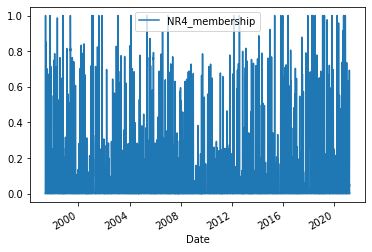

In [ ]:
A[['NR4_membership']].plot()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9433f6a9-5256-43e6-8a88-84eded61d4fc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>